# GMAC Optimization: Grid search of GMAC parameters

The GMAC algorithm has the following parameters required to map the raw acceleration
data to the arm-use space. These parameters are:
1. Moving average window size for pitch estimation. $\left( n_{p} \right)$
2. Butteworth highpass filter cut-off for accl. mag. estimation. $\left( f_{c} \right)$
3. Butteworth highpass filter order for accl. mag. estimation. $\left( n_{c} \right)$
4. Acceleration deadband threshold. $\left( a_{th0} \right)$
5. Moving average window for acceleration magnitude estimation. $\left( n_{am} \right)$
6. Pitch angle hysteresis lower threshold. $\left( \theta_{min} \right)$
7. Pitch angle hysteresis upper threshold. $\left( \theta_{max} \right)$
8. Acceleration magnitude hysteresis lower threshold. $\left( a_{min} \right)$
9.  Acceleration magnitude hysteresis upper threshold. $\left( a_{max} \right)$

## GMAC Algorithm

The GMAC algorithm is a combination of the gross movement (GM) algorithm and the 
activty counting (AC) algorithm. The GMAC algorithm, using only the accelerometer, 
tries to: (1) estimate the information used by GM and AC, forearm pitch angle and 
activity counts, respectively; and (2) applies thresholds on the estimated pitch 
and activity counting to estimate of the arm-use.

### Pitch Estimation
Pitch estimation is using the accelerometer data, and requies one to know the axis 
of accelerometer that is aligned with the forearm. The pitch is then estimated by 
estimating the arc-cosine of component of acceleration along this direction normalised 
by the magnitude of the acceleration due to gravity.

### Activity Counting Estimation
The activity counts is likely to be correlated to the magnitude of the highpass 
filtered acceleration.

### Applying thresholds
The pitch and activity counts are then thresholded to estimate the arm-use. 
Instead of applying a simple threshold algorithm that can be very sensitive to 
noise whenn the variable is close to the threshold, a thresholding procedure with 
hysteresis algorithm is used for both the pitch and the acceleration magnitude 
variables.

### Parameter search ranges
$F_s$ is the sampling frequency of the accelerometer data.
1. $n_{p} \in \left\{1, F_s/2, F_s, 2F_s, 5F_s\right\}$
2. $f_{c} \in [0.01, 0.1, 1]Hz \subset \mathbb{R}$
3. $n_{c} \in \left\{ 2, 4, 8\right\}$
4. $n_{am} \in \left\{1, F_s/2, F_s, 2F_s, 5F_s\right\}$
5. $a_{th0} \in \left\{ 0, 0.068, 0.68\right\}$
6. $\theta_{min}, \theta_{max} \in \left\{ 0, 20, \ldots +180 \right\}\deg$
7. $a_{min}, a_{max} \in \left\{0, 5, 10, 50, 100\right\}$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [198]:
%reload_ext autoreload
%autoreload 2

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [2]:
import seaborn as sns

### Custom Modules

In [3]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

## Define notebook level constants

In [4]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [5]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

### Functions implementing the GMAC algorithm

In [6]:
def estimate_pitch(accl_farm: np.array, nwin: int) -> np.array:
    """
    Estimates the pitch angle of the forearm from the accelerometer data.
    """
    # Moving averaging using the causal filter
    acclf = signal.lfilter(np.ones(nwin) / nwin, 1, accl_farm) if nwin > 1 else accl_farm
    acclf[acclf < -1] = -1
    acclf[acclf > 1] = 1        
    return -np.rad2deg(np.arccos(acclf)) + 90


def estimate_accl_mag(accl: np.array, fs: float, fc: float, nc: int,
                      deadband_th: float, n_am: int) -> np.array:
    """
    Compute the magnitude of the accelerometer signal.
    """
    # Highpass filter the acceleration data.
    sos = signal.butter(nc, fc, btype='highpass', fs=fs, output='sos')
    accl_filt = np.array([signal.sosfilt(sos, accl[:, 0]),
                          signal.sosfilt(sos, accl[:, 1]),
                          signal.sosfilt(sos, accl[:, 2])]).T
    
    # Zero load acceleration components.
    accl_filt[np.abs(accl_filt) < deadband_th] = 0
    
    # Acceleration magnitude    
    amag = np.linalg.norm(accl_filt, axis=1)
    
    # Moving average filter
    _input = np.append(np.ones(n_am - 1) * amag[0], amag)
    _impresp = np.ones(n_am) / n_am
    return np.convolve(_input, _impresp, mode='valid')

In [7]:
def estimation_param_combinations(param_ranges: dict) -> tuple:
    """
    Generate the list of parameter combinations for estimating the pitch and 
    acceleration magnitude.
    """
    # Pitch and accl. mag. estimation parameters
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _ath in param_ranges["deadband_th"]:
                    for _nam in param_ranges["nam"]:
                        yield (_np, _fc, _nc, _ath, _nam)


# Generate all possible combinations of parameters.
def generate_param_combinations(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _estparams in estimation_param_combinations(param_ranges):
        for i1, _pmax in enumerate(param_ranges["p_th"]):
            for _pmin in param_ranges["p_th"][:i1+1]:
                for i2, _amax in enumerate(param_ranges["am_th"]):
                    for _amin in param_ranges["am_th"][:i2+1]:
                        yield {
                            "np": int(_estparams[0]),
                            "fc": _estparams[1],
                            "nc": int(_estparams[2]),
                            "deadband_th": _estparams[3],
                            "nam": int(_estparams[4]),
                            "p_thmin": _pmin,
                            "p_thmax": _pmax,
                            "am_thmin": _amin,
                            "am_thmax": _amax
                        }

In [8]:
def apply_threshold_with_hysteresis(data: np.array, thmin: float, thmax: float,
                                    out0: float=0):
    """
    Applies threshold to the given data using the thmin and thmax thresholds.
    """
    _out = np.zeros(len(data))
    _out[0] = out0
    for i in range(1, len(_out)):
        if _out[i - 1] == 0:
            _out[i] = 1 if data[i] >= thmax else 0
        else:
            _out[i] = 0 if data[i] < thmin else 1
    return _out

In [9]:
def estimate_gmac(accl: np.array, accl_farm_inx: int, Fs: float, params: dict) -> np.array:
    """
    Estimate GMAC for the given acceleration data and parameters.
    """
    # Estimate pitch and acceleration magnitude
    pitch = estimate_pitch(accl[:, accl_farm_inx], params["np"])
    accl_mag = estimate_accl_mag(accl, Fs, fc=params["fc"], nc=params["nc"],
                                 deadband_th=params["deadband_th"],
                                 n_am=params["nam"])
    
    # Compute GMAC
    _pout = apply_threshold_with_hysteresis(pitch, params["p_thmin"], params["p_thmax"])
    _amout = apply_threshold_with_hysteresis(accl_mag, params["am_thmin"], params["am_thmax"])
    return _pout * _amout

In [10]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

#### Parameter ranges for the grid search

In [12]:
outdir = "../data/output"
limbkey = "right"
# Make directory if it does not exist
pathlib.Path(outdir, limbkey).mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
gmac_param_ranges = {
    "np": [1, Fs, 5*Fs],
    "fc": [0.01, 0.1, 1],
    "nc": [2, 4],
    "deadband_th": [0, 0.068, 0.68],
    "nam": [1, Fs, 5*Fs],
    "p_th": np.arange(-90, 90, 30),
    "am_th": [0, 1, 5, 10]
}

# Number of all possible combinations
Ncombs = len(list(generate_param_combinations(gmac_param_ranges)))

# All parameter combinations.
param_combs = list(generate_param_combinations(gmac_param_ranges))


In [14]:
# Which limb?
limbdf = datadf[limbkey]
subjects = limbdf.subject.unique()

# All param combinations.
init_df = lambda : pd.DataFrame(columns=["subject", "pcinx",
                                   "np", "fc", "nc", "deadband_th", "nam",
                                   "p_thmin", "p_thmax",
                                   "am_thmin", "am_thmax",
                                   "TN", "FP", "FN", "TP"])
analysisdf = init_df()

nrows_write = 1000

# Check if any files exist
_files = glob.glob(pathlib.Path(outdir, limbkey, f"analysisdf-*.csv").as_posix())
if len(_files) == 0:
    nrow_max = 0
else:
    nrow_max = np.max([int(_f.split(".csv")[0].split("-")[-1])
                    for _f in _files])
# Written file name
_wrtnfile = ''
_wrtnrows = 0
for i1, _pc in enumerate(generate_param_combinations(gmac_param_ranges)):
    # Check if data already exists
    if i1 // nrows_write < nrow_max:
        continue
    # All subjects
    for i2, _subj in enumerate(subjects):
        _sinx= limbdf.subject == _subj
        # All segments
        segs = limbdf[_sinx].segment.unique()
        _gmacs = []
        for i3, _seg in enumerate(segs):
            sys.stdout.write(f"\r[{limbkey}] [Wrote: ({_wrtnfile})({_wrtnrows})] Combination: {i1+1:8d}/{Ncombs:6d}; {i2+1:3d}/{len(subjects):3d}; {i3+1:2d}/{len(segs):2d}")
            sys.stdout.flush()
            _ainx = _sinx & (limbdf.segment == _seg)
            # Estimate GMAC
            _accl = limbdf.loc[_ainx, ['ax', 'ay', 'az']].values
            _gmacs.append(estimate_gmac(_accl, 0, Fs, _pc))
        
        # Estimate confusion matrix components
        _perf = compute_confusion_matrix(actual=limbdf.loc[_sinx, "gnd"].values,
                                         estimated=np.hstack(_gmacs))
        # Update analysis DF
        _rowdf = pd.DataFrame({"subject": _subj, "pcinx": i1} | _pc | _perf, index=[0])
        analysisdf = pd.concat([analysisdf,_rowdf],
                               axis=0, ignore_index=True)
    # Save data regularly
    if i1 > 0 and i1 % nrows_write == 0:
        _wrtnfile = f"analysisdf-{(i1 // nrows_write) - 1}.csv"
        _wrtnrows = len(analysisdf)
        analysisdf.to_csv(pathlib.Path(outdir, limbkey, _wrtnfile).as_posix(), index=False)
        analysisdf = init_df()

# Save whatever is left
_wrtnfile = f"analysisdf-{(i1 // nrows_write)}.csv"
_wrtnrows = len(analysisdf)
sys.stdout.write(f"\r[{limbkey}] [Wrote: ({_wrtnfile})({_wrtnrows})] Combination: {i1+1:8d}/{Ncombs:6d}; {i2+1:3d}/{len(subjects):3d}; {i3+1:2d}/{len(segs):2d}")
analysisdf.to_csv(pathlib.Path(outdir, limbkey, f"analysisdf-{(i1 // nrows_write)}.csv"), index=False)

[right] [Wrote: ()(0)] Combination:        1/ 34020;   1/ 10;  1/ 2

[right] [Wrote: (analysisdf-34.csv)(190)] Combination:    34020/ 34020;  10/ 10;  2/ 2 2

## Find the most appropriate paramters

In [15]:
def performance(yjvals: np.array) -> dict:
    """
    Computes the performance of the given GMAC.
    """
    if len(yjvals) == 0:
        return {
            "median": np.nan,
            "q5": np.nan,
            "q95": np.nan,
            "s90": np.nan,
            "perf": np.nan
        }
    q5, q50, q95 = np.percentile(yjvals, q=[5, 50, 95])
    return {
        "median": q50,
        "q5": q5,
        "q95": q95,
        "s90": q95 - q5,
        "perf": np.abs(q50 - 1) + 0.5 * (q95 - q5)
    }

In [16]:
def get_param_comb_difference(x1: np.array, x2: np.array) -> np.array:
    """Returns a custom distanc measure between two parameter combinations.
    """
    inx_cols = ["np", "fc", "nc", "deadband_th", "nam",
                "p_th", "p_th", "am_th", "am_th"]
    get_diff = lambda x, y, col: (np.where(gmac_param_ranges[col] == x)[0][0] -
                                np.where(gmac_param_ranges[col] == y)[0][0])
    return np.linalg.norm([get_diff(*v) for v in zip(x1, x2, inx_cols)], ord=1)

---
## With testing data

In [18]:
limbkey = "right"
# Read all data and combine into a sigle DF
files = glob.glob(pathlib.Path(outdir, limbkey, "analysisdf*.csv").as_posix())
allanalysisdf = pd.read_csv(files[0], index_col=False)
for _f in files[1:]:
    _df = pd.read_csv(_f, index_col=False)
    allanalysisdf = pd.concat([allanalysisdf, _df], axis=0, ignore_index=True)
allanalysisdf

,subject,pcinx,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,TN,FP,FN,TP
0,2,6001,1,0.10,4,0.000,50,-30,30,0,1,3343,2479,3136,15279
1,3,6001,1,0.10,4,0.000,50,-30,30,0,1,4411,234,5641,12713
2,4,6001,1,0.10,4,0.000,50,-30,30,0,1,4238,806,1731,14873
3,5,6001,1,0.10,4,0.000,50,-30,30,0,1,3593,419,3162,13058
4,6,6001,1,0.10,4,0.000,50,-30,30,0,1,8498,117,12873,5039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340195,7,12000,50,0.01,2,0.068,1,-90,-30,0,0,2,4979,2,19256
340196,8,12000,50,0.01,2,0.068,1,-90,-30,0,0,2,6653,0,20666
340197,9,12000,50,0.01,2,0.068,1,-90,-30,0,0,2,16401,0,20925
340198,10,12000,50,0.01,2,0.068,1,-90,-30,0,0,2,6615,2,16471


In [19]:
# Compute different performance metrics
# Sensitivity
allanalysisdf["sensitivity"] = allanalysisdf.TP / (allanalysisdf.TP + allanalysisdf.FN)
# Specificity
allanalysisdf["specificity"] = allanalysisdf.TN / (allanalysisdf.TN + allanalysisdf.FP)
# Youden's J
allanalysisdf["youden"] = allanalysisdf.sensitivity + allanalysisdf.specificity - 1

# Save analysis DF
allanalysisdf.to_csv(pathlib.Path(outdir, limbkey, "allanalysisdf.csv"), index=False)

In [20]:
# Subjects
subjs = np.sort(allanalysisdf.subject.unique())
q = 95

# Optimization data frame
optdf = pd.DataFrame(columns=["pcinx", "median", "q95", "q5", "s90", "cost", "testval", "testsubj"])
for _nc in range(Ncombs):
    for sinx in range(len(subjs)):
        sys.stdout.write(f"\rCombination: {_nc+1:8d}/{Ncombs:6d}; {sinx+1:3d}/{len(subjs):3d}")
        sys.stdout.flush()
        testsubj = subjs[sinx]
        trainsubj = subjs[~(subjs == testsubj)]
        
        # Find the best parameter combination for the training subjects.
        _subjtraininx = allanalysisdf.subject.isin(trainsubj)
        _subjtestinx = allanalysisdf.subject == testsubj
        _inxtrain = allanalysisdf.pcinx == _nc
        _inxtest = allanalysisdf.pcinx == _nc
        
        # Find the best parameter combination for the training subjects.
        _yitrain = allanalysisdf.loc[_subjtraininx & _inxtrain, "youden"]
        _yitest = allanalysisdf.loc[_subjtestinx & _inxtest, "youden"]
        
        # Performance vairables.
        _perf = performance(_yitrain.values)
        _perfdf = pd.DataFrame({
            "pcinx": _nc,
            "median": _perf["median"],
            "q95": _perf["q95"],
            "q5": _perf["q5"],
            "s90": _perf["s90"],
            "cost": _perf["perf"],
            "testval": _yitest.values,
            "testsubj": testsubj
        })
        optdf = pd.concat([optdf, _perfdf], ignore_index=True)

# Save the optimization data frame        
optdf.to_csv(pathlib.Path(outdir, limbkey, f"optdf.csv"), index=False)

Combination:    34020/ 34020;  10/ 10

In [25]:
limbkey = "unaff"
optdf = pd.read_csv(pathlib.Path(outdir, limbkey, f"optdf.csv"), index_col=False)

# Go through each validation subject, and choose the best training cost 
# parameter combination.
bestparamsdf = pd.DataFrame(columns=["subj", "lbound", "bestpinx", "bestval"])
for _subj in optdf.testsubj.unique():
    # _minval = np.min(optdf.loc[optdf.testsubj == _subj, "cost"])
    _sinx = optdf.testsubj == _subj
    _lbound = np.percentile(optdf.loc[optdf.testsubj == _subj, "cost"], 0.01)
    _bpins = list(np.where(optdf.loc[_sinx, "cost"] <= _lbound)[0])
    _bval = list(optdf.loc[_sinx, "testval"].values[_bpins])
    bestparamsdf = pd.concat([bestparamsdf, 
                              pd.DataFrame({"subj": [_subj] * len(_bpins),
                                            "lbound": [_lbound] * len(_bpins),
                                            "bestpinx": _bpins,
                                            "bestval": _bval})],
                             ignore_index=True)
# Save the optimization data frame
bestparamsdf.to_csv(pathlib.Path(outdir, limbkey, f"bestparamsdf.csv"), index=False)

## Choosing the best parameters

In [26]:
# Read the optimization data frame for the two limbs for healthy controls and
# stroke subjects
allanalysisdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"allanalysisdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"allanalysisdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"allanalysisdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"allanalysisdf.csv"), index_col=False),
}

optdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"optdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"optdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"optdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"optdf.csv"), index_col=False),
}

bestparamsdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"bestparamsdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"bestparamsdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"bestparamsdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"bestparamsdf.csv"), index_col=False),
}

# # Dataframe of the best parameter combinations
# best_pc_vals_df = {
#     "left": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["left"]["bestpinx"]]),
#     "right": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["right"]["bestpinx"]]),
#     "aff": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["aff"]["bestpinx"]]),
#     "unaff": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["unaff"]["bestpinx"]]),
# }

In [27]:
# Best parameters
bpc = pd.DataFrame(columns=["limb", "subj", "np", "fc", "nc", "deadband_th", "nam", "p_thmin", "p_thmax", "am_thmin", "am_thmax", ])
for lkey in ["left", "right", "aff", "unaff"]:
    for ns in bestparamsdf[lkey]['subj'].unique():
        ns_inx = bestparamsdf[lkey]['subj'] == ns
        bpc_inx = bestparamsdf[lkey].loc[ns_inx, "bestpinx"].values
        bpc_vals_df = pd.DataFrame.from_dict([param_combs[_inx] for _inx in bpc_inx])
        # print("----------")
        # print("Ns: ", ns)
        # # np
        # print(bpc_vals_df.np.value_counts())
        # # fc-nc
        # print(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
        # # deadband_th
        # print(bpc_vals_df.deadband_th.value_counts())
        # # nam
        # print(bpc_vals_df.nam.value_counts())
        # # p_th
        # print(bpc_vals_df.loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
        # # am_th
        # print(bpc_vals_df.loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
        
        # # Extract the highest value
        # print(", ".join((f"{bpc_vals_df.np.value_counts().index[0]}",
        #                  f"{bpc_vals_df.loc[:, ['fc', 'nc']].apply(lambda x: f'{x[0]}:{x[1]}', axis=1).value_counts().index[0]}",
        #                  f"{bpc_vals_df.deadband_th.value_counts().index[0]}",
        #                  f"{bpc_vals_df.nam.value_counts().index[0]}",
        #                  f"{bpc_vals_df.loc[:, ['p_thmin', 'p_thmax']].apply(lambda x: f'{x[0]}:{x[1]}', axis=1).value_counts().index[0]}",
        #                  f"{bpc_vals_df.loc[:, ['am_thmin', 'am_thmax']].apply(lambda x: f'{x[0]}:{x[1]}', axis=1).value_counts().index[0]}")))
        
        bpc = pd.concat([
            bpc,
            pd.DataFrame.from_dict({
                "limb": [lkey], "subj": [ns],
                "np": [bpc_vals_df.np.value_counts().index[0]],
                "fc": [float(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[0])],
                "nc": [int(float(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[1]))],
                "deadband_th": [bpc_vals_df.deadband_th.value_counts().index[0]],
                "nam": [bpc_vals_df.nam.value_counts().index[0]],
                "p_thmin": [int(bpc_vals_df.loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[0])],
                "p_thmax": [int(bpc_vals_df.loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[1])],
                "am_thmin": [int(bpc_vals_df.loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[0])],
                "am_thmax": [int(bpc_vals_df.loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[1])]
            })
        ], axis=0, ignore_index=True)
bpc

,limb,subj,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,pcinx
0,left,1,250,0.01,2,0.00,1,-30,0,0,0,NaN
1,left,2,250,0.01,2,0.00,1,-30,0,0,0,NaN
2,left,3,1,0.01,4,0.00,50,-30,0,0,1,NaN
3,left,4,1,0.01,4,0.00,50,-30,-30,0,1,NaN
4,left,5,1,0.01,2,0.00,1,-30,0,0,0,NaN
5,left,6,50,0.01,4,0.00,1,-30,0,0,0,NaN
6,left,7,250,0.01,2,0.00,1,-30,0,0,0,NaN
7,left,8,1,0.01,4,0.00,50,-30,0,0,1,NaN
8,left,9,250,0.01,2,0.00,1,-30,0,0,0,NaN
9,left,10,250,0.01,2,0.00,1,-30,0,0,0,NaN


In [28]:
param_cols = [_c for _c in bpc.columns if _c not in ['subj', 'limb', 'pcinx', 'youden']]
pcarray = pd.DataFrame.from_dict(param_combs).to_numpy()
for i in bpc.index:
    lkey = bpc.loc[i, 'limb']
    bpc.loc[i, 'pcinx'] = int(np.where(np.all(pcarray == bpc.loc[i, param_cols].to_numpy(), axis=1))[0][0])
    _sinx = allanalysisdf[lkey]['subject'] == bpc.loc[i, 'subj']
    _pinx = allanalysisdf[lkey]['pcinx'] == bpc.loc[i, 'pcinx']
    bpc.loc[i, 'youden'] = allanalysisdf[lkey].loc[_sinx & _pinx, 'youden'].values[0]
bpc

,limb,subj,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,pcinx,youden
0,left,1,250,0.01,2,0.00,1,-30,0,0,0,22760,0.315096
1,left,2,250,0.01,2,0.00,1,-30,0,0,0,22760,0.309036
2,left,3,1,0.01,4,0.00,50,-30,0,0,1,2181,0.355378
3,left,4,1,0.01,4,0.00,50,-30,-30,0,1,2151,0.409120
4,left,5,1,0.01,2,0.00,1,-30,0,0,0,80,0.277307
5,left,6,50,0.01,4,0.00,1,-30,0,0,0,13310,0.510148
6,left,7,250,0.01,2,0.00,1,-30,0,0,0,22760,0.306403
7,left,8,1,0.01,4,0.00,50,-30,0,0,1,2181,0.389268
8,left,9,250,0.01,2,0.00,1,-30,0,0,0,22760,0.233165
9,left,10,250,0.01,2,0.00,1,-30,0,0,0,22760,0.301329


Text(0.5, 1.0, "Youden's index")

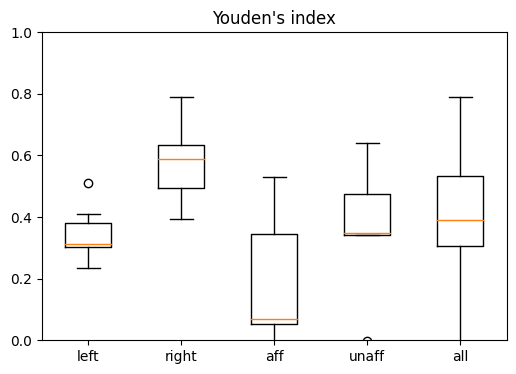

In [33]:
# Find out performance
yinx = []
for lkey in ["left", "right", "aff", "unaff"]:
    yinx.append([])
    for i in bpc.loc[bpc['limb'] == lkey, :].index:
        _sinx = allanalysisdf[lkey]['subject'] == bpc.loc[i, 'subj']
        _pinx = allanalysisdf[lkey]['pcinx'] == bpc.loc[i, 'pcinx']
        yinx[-1].append(allanalysisdf[lkey].loc[_sinx & _pinx, 'youden'].values[0])

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.boxplot(yinx + [[z for x in yinx for z in x]], notch=False,
           labels=["left", "right", "aff", "unaff", "all"])
ax.set_ylim(0.0, 1.0)
ax.set_title("Youden's index")

---
## Not worrying about "testing" data

In [126]:
limbkey = "left"
# Read all data and combine into a sigle DF
files = glob.glob(pathlib.Path(outdir, limbkey, "analysisdf*.csv").as_posix())
allanalysisdf = pd.read_csv(files[0], index_col=False)
for _f in files[1:]:
    _df = pd.read_csv(_f, index_col=False)
    allanalysisdf = pd.concat([allanalysisdf, _df], axis=0, ignore_index=True)
allanalysisdf

,subject,pcinx,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,TN,FP,FN,TP
0,2,6001,1,0.10,4,0.000,50,-30,30,0,1,7049,80,15878,1255
1,3,6001,1,0.10,4,0.000,50,-30,30,0,1,4902,4125,5006,8142
2,4,6001,1,0.10,4,0.000,50,-30,30,0,1,5210,2669,6776,7069
3,5,6001,1,0.10,4,0.000,50,-30,30,0,1,4605,3466,5838,6371
4,6,6001,1,0.10,4,0.000,50,-30,30,0,1,7551,1715,10608,6654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340195,7,12000,50,0.01,2,0.068,1,-90,-30,0,0,3,9268,1,14234
340196,8,12000,50,0.01,2,0.068,1,-90,-30,0,0,2,7967,0,19449
340197,9,12000,50,0.01,2,0.068,1,-90,-30,0,0,3,21155,0,16160
340198,10,12000,50,0.01,2,0.068,1,-90,-30,0,0,3,8690,1,13573


In [127]:
# Compute different performance metrics
# Sensitivity
allanalysisdf["sensitivity"] = allanalysisdf.TP / (allanalysisdf.TP + allanalysisdf.FN)
# Specificity
allanalysisdf["specificity"] = allanalysisdf.TN / (allanalysisdf.TN + allanalysisdf.FP)
# Youden's J
allanalysisdf["youden"] = allanalysisdf.sensitivity + allanalysisdf.specificity - 1

# Save analysis DF
allanalysisdf.to_csv(pathlib.Path(outdir, limbkey, "allanalysisdf.csv"), index=False)

In [128]:
# Subjects
subjs = np.sort(allanalysisdf.subject.unique())
q = 95

# Optimization data frame
optdf = pd.DataFrame(columns=["pcinx", "median", "q95", "q5", "s90", "cost"])
for _nc in range(Ncombs):
    sys.stdout.write(f"\rCombination: {_nc+1:8d}/{Ncombs:6d}")
    sys.stdout.flush()
    
    # Performance vairables.
    _perf = performance(allanalysisdf.loc[allanalysisdf.pcinx == _nc, "youden"].values)
    _perfdf = pd.DataFrame({
        "pcinx": _nc,
        "median": _perf["median"],
        "q95": _perf["q95"],
        "q5": _perf["q5"],
        "s90": _perf["s90"],
        "cost": _perf["perf"],
    }, index=[0])
    optdf = pd.concat([optdf, _perfdf], ignore_index=True)

# Save the optimization data frame        
optdf.to_csv(pathlib.Path(outdir, limbkey, f"optdf-notest.csv"), index=False)

Combination:    34020/ 34020

In [184]:
# limbkey = "unaff"
optdf = pd.read_csv(pathlib.Path(outdir, limbkey, f"optdf-notest.csv"), index_col=False)

# Go through each validation subject, and choose the best training cost 
# parameter combination.
bestparamsdf = pd.DataFrame(columns=["lbound", "bestpinx"])
_lbound = np.nanpercentile(optdf.loc[:, "cost"], 0.1)
_bpins = list(np.where(optdf.loc[:, "cost"] <= _lbound)[0])
bestparamsdf = pd.concat([bestparamsdf, 
                            pd.DataFrame({"lbound": [_lbound] * len(_bpins),
                                          "bestpinx": _bpins})],
                            ignore_index=True)
# Save the optimization data frame
bestparamsdf.to_csv(pathlib.Path(outdir, limbkey, f"bestparamsdf-notest.csv"), index=False)

In [185]:
bestparamsdf

,lbound,bestpinx
0,0.692406,110
1,0.692406,111
2,0.692406,320
3,0.692406,530
4,0.692406,740
...,...,...
81,0.692406,17131
82,0.692406,17691
83,0.692406,17721
84,0.692406,17761


---
# Choosing the optimal parameters for healthy and stroke subjects

In [218]:
# Read the optimization data frame for the two limbs for healthy controls and
# stroke subjects
allanalysisdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"allanalysisdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"allanalysisdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"allanalysisdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"allanalysisdf.csv"), index_col=False),
}

optdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"optdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"optdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"optdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"optdf.csv"), index_col=False),
}

bestparamsdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"bestparamsdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"bestparamsdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"bestparamsdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"bestparamsdf.csv"), index_col=False),
}

# Dataframe of the best parameter combinations
best_pc_vals_df = {
    "left": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["left"]["bestpinx"]]),
    "right": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["right"]["bestpinx"]]),
    "aff": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["aff"]["bestpinx"]]),
    "unaff": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["unaff"]["bestpinx"]]),
}

In [220]:
# np
print("\nleft")
print(best_pc_vals_df["left"].np.value_counts())
print("\nright")
print(best_pc_vals_df["right"].np.value_counts())
print("\naff")
print(best_pc_vals_df["aff"].np.value_counts())
print("\nunaff")
print(best_pc_vals_df["unaff"].np.value_counts())


left
np
250    306
1      248
50      66
Name: count, dtype: int64

right
np
250    650
Name: count, dtype: int64

aff
np
1      257
50      19
250      9
Name: count, dtype: int64

unaff
np
1      190
50      31
250     15
Name: count, dtype: int64


In [208]:
# fc, nc
print("\nleft")
print(best_pc_vals_df["left"].loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\nright")
print(best_pc_vals_df["right"].loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\naff")
print(best_pc_vals_df["aff"].loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\nunaff")
print(best_pc_vals_df["unaff"].loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())


left
0.01:4.0    780
0.01:2.0    663
0.1:2.0     610
0.1:4.0     595
1.0:2.0     508
1.0:4.0     490
Name: count, dtype: int64

right
0.01:4.0    678
0.01:2.0    641
1.0:2.0     604
0.1:2.0     583
0.1:4.0     568
1.0:4.0     484
Name: count, dtype: int64

aff
1.0:4.0     396
0.01:4.0    376
0.1:2.0     337
0.01:2.0    330
0.1:4.0     292
1.0:2.0     282
Name: count, dtype: int64

unaff
0.1:4.0     386
0.1:2.0     326
0.01:4.0    317
0.01:2.0    298
1.0:2.0     237
1.0:4.0     233
Name: count, dtype: int64


In [209]:
# deadband_th
print("\nleft")
print(best_pc_vals_df["left"].deadband_th.value_counts())
print("\nright")
print(best_pc_vals_df["right"].deadband_th.value_counts())
print("\naff")
print(best_pc_vals_df["aff"].deadband_th.value_counts())
print("\nunaff")
print(best_pc_vals_df["unaff"].deadband_th.value_counts())


left
deadband_th
0.000    1300
0.068    1300
0.680    1046
Name: count, dtype: int64

right
deadband_th
0.000    1229
0.068    1216
0.680    1113
Name: count, dtype: int64

aff
deadband_th
0.680    746
0.068    634
0.000    633
Name: count, dtype: int64

unaff
deadband_th
0.000    612
0.068    612
0.680    573
Name: count, dtype: int64


In [210]:
# nam
print("\nleft")
print(best_pc_vals_df["left"].nam.value_counts())
print("\nright")
print(best_pc_vals_df["right"].nam.value_counts())
print("\naff")
print(best_pc_vals_df["aff"].nam.value_counts())
print("\nunaff")
print(best_pc_vals_df["unaff"].nam.value_counts())


left
nam
1      1510
50     1164
250     972
Name: count, dtype: int64

right
nam
1      1640
50     1044
250     874
Name: count, dtype: int64

aff
nam
1      965
50     540
250    508
Name: count, dtype: int64

unaff
nam
1      991
50     424
250    382
Name: count, dtype: int64


In [211]:
# p_th
print("\nleft")
print(best_pc_vals_df["left"].loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\nright")
print(best_pc_vals_df["right"].loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\naff")
print(best_pc_vals_df["aff"].loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\nunaff")
print(best_pc_vals_df["unaff"].loc[:, ["p_thmin", "p_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())


left
-30:0      1808
-30:-30    1137
-60:0       345
0:0         345
-60:-30      11
Name: count, dtype: int64

right
0:0       1836
-30:30    1028
-60:30     398
-30:0      136
30:30      130
0:30        30
Name: count, dtype: int64

aff
0:30       429
-30:0      309
-60:30     262
30:30      196
-30:30     190
-90:-90    174
-90:-60    120
-90:-30    120
0:0         87
-30:-30     37
-60:0       31
-60:-30     21
-60:-60     18
-90:0       16
-90:30       3
Name: count, dtype: int64

unaff
-30:30     541
-60:30     297
-30:-30    249
-30:0      245
0:0        198
-60:0      128
-60:60      71
-60:-30     49
-60:-60     16
-90:0        2
0:30         1
Name: count, dtype: int64


In [212]:
# am_th
print("\nleft")
print(best_pc_vals_df["left"].loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\nright")
print(best_pc_vals_df["right"].loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\naff")
print(best_pc_vals_df["aff"].loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())
print("\nunaff")
print(best_pc_vals_df["unaff"].loc[:, ["am_thmin", "am_thmax"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts())


left
0:0    2916
0:1     730
Name: count, dtype: int64

right
0:0    2518
0:1    1010
1:1      30
Name: count, dtype: int64

aff
0:0    1512
0:1     459
1:1      42
Name: count, dtype: int64

unaff
0:0    1080
0:1     717
Name: count, dtype: int64


(0.0, 1.0)

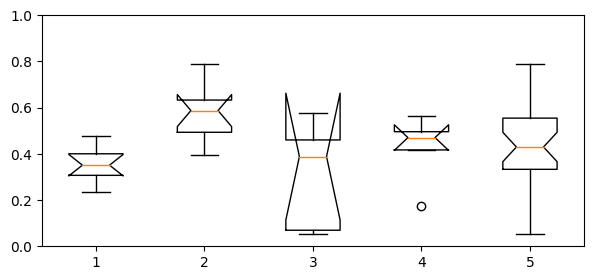

In [213]:
# Performance of the optimal parameter combinations
opt_pc = {
    "left": [250, 0.01, 2, 0.0, 1, -30, 0, 0, 0],
    "right": [250, 0.01, 2, 0.0, 1, 0, 0, 0, 0],
    "aff": [1, 0.01, 2, 0.0, 1, 0, 30, 0, 0],
    "unaff": [1, 0.01, 2, 0.0, 1, -60, 30, 0, 0],
}

# Optimal index for each limb
pcarray = pd.DataFrame.from_dict(param_combs).to_numpy()
pcinx = {k: np.where(np.all(pcarray == v, axis=1))[0][0]
         for k, v in opt_pc.items()}

# Plot the performance of the optimal parameter combinations
limbkeys = ["left", "right", "aff", "unaff"]
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
_xvals = [allanalysisdf[k].loc[allanalysisdf[k].pcinx == pcinx[k], "youden"].values
          for k in limbkeys]
ax.boxplot(_xvals + [np.array([_z for _y in _xvals for _z in _y])], notch=True)
ax.set_ylim(0, 1.0)

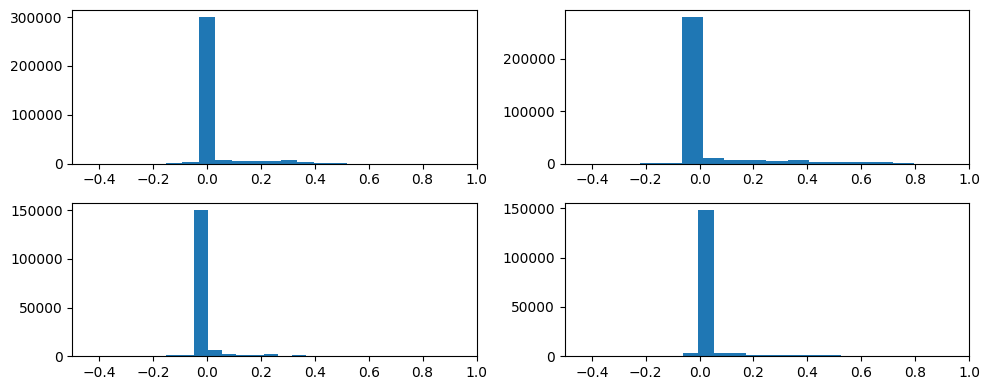

In [180]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(221)
ax.hist(allanalysisdf["left"]["youden"].values, bins=20);
ax.set_xlim(-0.5, 1.0)
ax = fig.add_subplot(222)
ax.hist(allanalysisdf["right"]["youden"].values, bins=20);
ax.set_xlim(-0.5, 1.0)
ax = fig.add_subplot(223)
ax.hist(allanalysisdf["aff"]["youden"].values, bins=20);
ax.set_xlim(-0.5, 1.0)
ax = fig.add_subplot(224)
ax.hist(allanalysisdf["unaff"]["youden"].values, bins=20);
ax.set_xlim(-0.5, 1.0)
plt.tight_layout()